In [30]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
sys.path.append("/Users/kmarvel/Google Drive/python-utils")

import CMIP5_tools as cmip5
import DA_tools
import Plotting

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline

# Data
Regional monthly mean precipitation data has been calculated for the central/eastern Sahel (east of 0$^{\circ}$ longitude) and the western Sahel (west) in all CMIP5 models and three observational datasets.

In [31]:
cmip_directory = "/Users/kmarvel/Google Drive/Sahel/DATA/CMIP5/INTENSITY/"
obs_directory = "/Users/kmarvel/Google Drive/Sahel/DATA/OBS/PROCESSED/"

In [32]:
def by_month(X):
    """
    X is a cdat variable with a labeled time axis with time step = 1 month.
    This function returns variable with one extra axis with shape (12)
    """
    time_i=X.getAxisIds().index('time')
    nm=X.shape[time_i]
    nyears = int(nm/12)
    newtime=(nyears,12)
    d={}
    for i in range(len(X.shape)):
        d[i]=X.shape[i]
    d[time_i]=newtime
    #now make the new shape
    newshape=()
    for i in range(len(X.shape)):
        x=d[i]
        if type(x)==type(()):
            newshape+=x
        else:
            newshape+=(x,)
    Xr=MV.array(X.asma().reshape(newshape))
    axlist = range(len(X.shape))
    for i in axlist:
        if i != time_i:
            Xr.setAxis(i,X.getAxis(i)) 
    monthax = cdms.createAxis(np.arange(12)+1)
    monthax.id="months"
    monthax.months=str(["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"])
    Xr.setAxis(time_i+1,monthax)
    
    yearax = cdms.createAxis(X.getTime()[6::12])
    for att in X.getTime().attributes:
        setattr(yearax,att,X.getTime().attributes[att])
    
    yearax.id="time"
    yearax.designateTime()
    Xr.setAxis(time_i,yearax)
    
    return Xr



In [73]:
class CMIP5DATA():
    """
    Get east, west, and total Sahel precipitation data.  
    Experiment can be one of
    *1pctCO2
    *AA
    *historical
    *historicalGHG
    *historical-rcp85 (spliced)
    *piControl
    *rcp85
    """
    def __init__(self,experiment,base_period=None):
        if base_period is None:
            base_period=('1900-1-1','1950-12-31')
        f=cdms.open(cmip_directory+"cmip5.sahel_precip_intensity."+experiment+".nc")
        
        #total=f("pr_sahel")
        #f.close()
        self.raw={}
        self.bymonth={}
        self.anomalies={}
        self.climatology={}
        self.mma={}
        for variable in ["pr_CE","intensity_CE","pr_W","intensity_W"]:
            #raw data
            data=f(variable)
            self.raw[variable]=data
            #partitioned by month
            bymonth=by_month(data)
            self.bymonth[variable]=bymonth
            #climatology
            clim=MV.average(bymonth(time=base_period),axis=1)
            self.climatology[variable]=clim
            #anomalies
            anomalies=cmip5.cdms_clone(bymonth.asma()-clim.asma()[:,np.newaxis,:],bymonth)
            self.anomalies[variable]=anomalies
            #multi-model average (first average over ensemble members, then models)
            mma=MV.average(cmip5.ensemble2multimodel(anomalies),axis=0)
            self.mma[variable]=mma
    def fingerprint(self,include=["pr_CE","intensity_CE","pr_W","intensity_W"],time_bounds=None):
        if time_bounds is None:
            time_bounds = (cmip5.start_time(self.mma["pr_CE"]),cmip5.stop_time(self.mma["pr_CE"]))
        if (type(include)==type("string")):
            solver=Eof(self.mma(include)(time=time_bounds))
        else:
            data=[]
            for incl in include:
                data+=[self.mma[incl](time=time_bounds)/np.std(self.mma[incl](time=time_bounds))]
                solver=MultivariateEof(data)
        solver.variables=include
        return solver
    
    def project_on_solver(self,projections_from=None,include=["pr_CE","intensity_CE","pr_W","intensity_W"],eof_number=0):
        if projections_from is None:
            projections_from=self
        solver=self.fingerprint(include=include)
        fac=DA_tools.get_orientation(solver)
        nmod,nyears,nmonths=getattr(projections_from,"anomalies")["pr_CE"].shape
        P=MV.zeros((nmod,nyears))
        
        for modeli in range(nmod):
            
            if (type(include)==type("string")):
                to_proj=getattr(projections_from,"anomalies")[include][modeli]
            else:
                to_proj=[]
                for incl in include:
                    dat=getattr(projections_from,"anomalies")[incl][modeli]
                    to_proj+=[dat/np.std(dat)]
            P[modeli]=solver.projectField(to_proj)[:,eof_number]*fac
        P.setAxis(0,getattr(projections_from,"anomalies")["pr_CE"].getAxis(0))
        P.setAxis(1,getattr(projections_from,"anomalies")["pr_CE"].getAxis(1))
        return P
        
            
        
            
def plot_multivariate(solver,i=0,fac=None):
    pr_CE_eofs,intensity_CE_eofs,pr_W_eofs,intensity_W_eofs=solver.eofs()
    if fac is None:
        fac=DA_tools.get_orientation(solver)
    plt.plot(pr_CE_eofs[i].asma()*fac,c=cm.PuOr(.9),label="East: precipitation")
    plt.plot(intensity_CE_eofs[i].asma()*fac,c=cm.PuOr(.8),ls=":",label="East: intensity")

    plt.plot(pr_W_eofs[i].asma()*fac,c=cm.PuOr(.2),label="West: precipitation")
    plt.plot(intensity_W_eofs[i].asma()*fac,c=cm.PuOr(.1),ls=":",label="West: intensity")
    months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    plt.xticks(np.arange(12),months)
    plt.legend()
    plt.axhline(0,c="k",ls=":")
    

In [45]:

base_period=('1950-1-1','1979-12-31')
h85=CMIP5DATA("historical-rcp85")
solver=h85.fingerprint()
aa=CMIP5DATA("AA")
aasolver = aa.fingerprint()

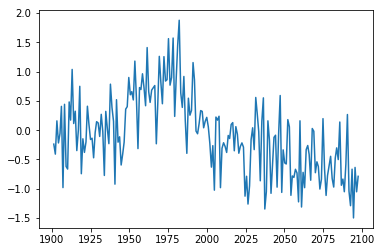

In [48]:
Paa=aa.project_on_solver(projections_from=h85)
Plotting.time_plot(MV.average(Paa,axis=0))

In [49]:
def bootstrap_slopes(noise,L):
    nt=noise.shape[0]-L
    test = MV.zeros((nt,L))
    
    for i in range(nt):
        test[i]=noise[i:L+i]
    test.setAxis(1,noise[:L].getAxis(0))
    return cmip5.get_linear_trends(test)  


The fingerprint of aerosols (leading EOF) looks like the inverse of EOF2 for the historical-rcp85 simulation

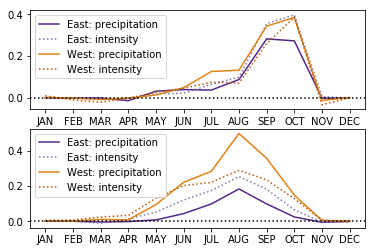

In [74]:
plt.subplot(211)
plot_multivariate(aasolver,fac=-1)
plt.subplot(212)
plot_multivariate(solver,i=1)

Is this just an artifact of the aerosol-only runs being different models?  To check this, look at h85 fingerprint using only those models that also did aerosol-only runs with daily data:

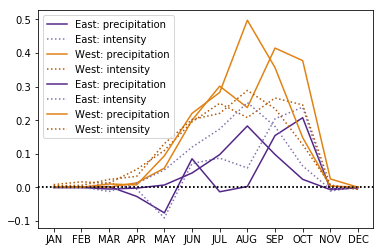

In [145]:
aa_models=cmip5.models(aa.raw["pr_CE"])

h85_models=cmip5.models(h85.raw["pr_CE"])
aamod=[y.split(".")[1] for y in aa_models]
h85mod=[y.split(".")[1] for y in h85_models]
okmods=np.intersect1d(np.unique(aamod),np.unique(h85mod))
h85_keep=[]
for model in h85mod:
    if model in okmods:
        h85_keep+=[h85mod.index(model)]
newanoms={}
newmma={}
for key in h85.anomalies.keys():
    data=h85.anomalies[key]
    modax,tax,monthax=data.getAxisList()
    newdata=MV.array(data.asma()[np.array(h85_keep)])
    newmodax=cmip5.make_model_axis(np.array(h85_models)[np.array(h85_keep)].tolist())
    newdata.setAxisList([newmodax,tax,monthax])
    newdata.id=data.id
    newanoms[key]=newdata
    #print(cmip5.ensemble2multimodel(newdata).shape)
    newmma[key]=MV.average(cmip5.ensemble2multimodel(newdata),axis=0)
class SelectCMIP5DATA(CMIP5DATA):
    def __init__(self,experiment,newanoms,newmma):
        self.mma=newmma
        self.anomalies=newanoms
            
select_h85=SelectCMIP5DATA("historical-rcp85",newanoms,newmma)    
plot_multivariate(select_h85.fingerprint() ,i=1 ) 
plot_multivariate(h85.fingerprint(),i=1)

PC2 (associated with EOF2) of historical-rcp85 tracks PC1 (associated with leading EOF) of aerosol-only simulations very well over the historical period

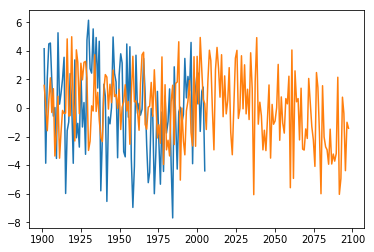

In [146]:
Plotting.time_plot(-1*aasolver.pcs()[:,0])
Plotting.time_plot(select_h85.fingerprint().pcs()[:,1])


Contrast this with the leading EOF for h85

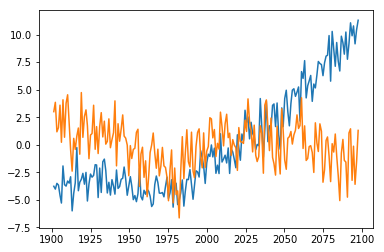

In [9]:
P=h85.project_on_solver(eof_number=0)
#Plotting.time_plot(MV.average(cmip5.ensemble2multimodel(P),axis=0))
Plotting.time_plot(solver.pcs()[:,0])
Plotting.time_plot(solver.pcs()[:,1])

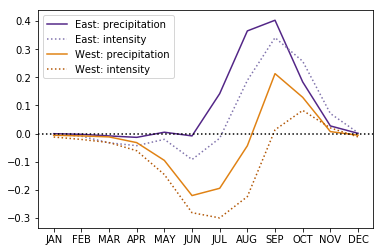

In [10]:
solver=h85.fingerprint()
plot_multivariate(solver,i=0)
plt.axhline(0,c="k",ls=":")

TypeError: unsupported operand type(s) for *: 'int' and 'MultivariateEof'

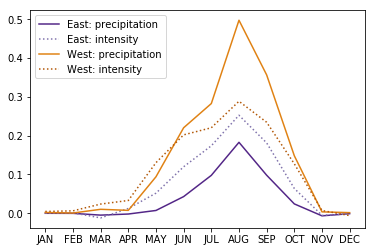

In [69]:
plot_multivariate(solver,i=1)
plot_multivariate(aasolver)
plt.axhline(0,c="k",ls=":")

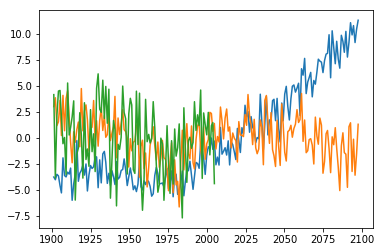

In [63]:
fac=DA_tools.get_orientation(solver)
Plotting.time_plot(solver.pcs()[:,0]*fac)
Plotting.time_plot(solver.pcs()[:,1]*fac)
Plotting.time_plot(aasolver.pcs()[:,0]*-1)

In [29]:
class PICONTROLDATA():
    """
    Get east, west, and total Sahel precipitation data.  
    Experiment can be one of
    *1pctCO2
    *AA
    *historical
    *historicalGHG
    *historical-rcp85 (spliced)
    *piControl
    *rcp85
    """
    def __init__(self):
        
        f=cdms.open(cmip_directory+"cmip5.sahel_precip_intensity.piControl.nc")
        
        #total=f("pr_sahel")
        #f.close()
        self.raw={}
        self.bymonth={}
        self.anomalies={}
        self.climatology={}
        self.concatenated={}
        for variable in ["pr_CE","intensity_CE","pr_W","intensity_W"]:
            #raw data
            data=f(variable)
            self.raw[variable]=data
            #partitioned by month
            bymonth=by_month(data)
            self.bymonth[variable]=bymonth
            #climatology
            clim=MV.average(bymonth,axis=1)
            self.climatology[variable]=clim
            #anomalies
            anomalies=cmip5.cdms_clone(bymonth.asma()-clim.asma()[:,np.newaxis,:],bymonth)
            self.anomalies[variable]=anomalies
            #multi-model average (first average over ensemble members, then models)
            concatenated=DA_tools.concatenate_this(anomalies)
            self.concatenated[variable]=concatenated
    def fingerprint(self,include=["pr_CE","intensity_CE","pr_W","intensity_W"]):
        if (type(include)==type("string")):
            solver=Eof(self.concatenated(include))
        else:
            data=[]
            for incl in include:
                data+=[self.concatenated[incl]/np.std(self.concatenated[incl])]
                solver=MultivariateEof(data)
        solver.variables=include
        return solver
    
    def project_on_solver(self,solver,include=["pr_CE","intensity_CE","pr_W","intensity_W"],eof_number=0):
        #solver=self.fingerprint(include=include)
        fac=DA_tools.get_orientation(solver)
        nmod,nyears,nmonths=self.anomalies["pr_CE"].shape
        to_proj=[]
        
            
        for incl in include:
            dat=self.concatenated[incl]
            to_proj+=[dat/np.std(dat)]
        P=solver.projectField(to_proj)[:,eof_number]*fac
       
        return P
        
            

Project the pre-industrial control onto the solver to get a measure of noise

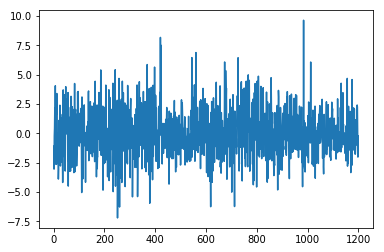

In [14]:
piC=PICONTROLDATA()
solver=h85.fingerprint()
picproj=piC.project_on_solver(solver)
Plotting.time_plot(picproj)

Leading noise mode: EOF1 of concatenated pre-industrial control simulations.  Compare this to the fingerprint and second EOF.

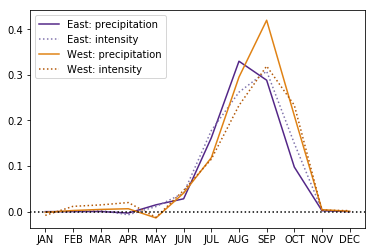

In [15]:
piC=PICONTROLDATA()
leading_noise_mode=piC.fingerprint()
plot_multivariate(leading_noise_mode,i=0)

plt.axhline(0,c="k",ls=":")

In [51]:
def TOE(projections,noise,starttime=None,L_init=30):
    nmod,nyears=projections.shape
    
    
    if starttime is None:
        starttime=cdtime.comptime(2000,1,1)
    endtime=starttime.add(L_init,cdtime.Years)
    y2100=cdtime.comptime(2100,1,1)
    yrs=2100-endtime.year+1
    SN=MV.zeros((nmod,yrs))
    
    counter=0
    while endtime.cmp(y2100)<=0:
        trunc=projections(time=(starttime,endtime))
        L=trunc.shape[1]
        signals=cmip5.get_linear_trends(trunc)
        
        slopes=bootstrap_slopes(noise,L)
        SN[:,counter]=signals/np.std(slopes)
        endtime=endtime.add(1,cdtime.Years)
        counter+=1
    SN.setAxis(0,projections.getAxis(0))
    tax=cdms.createAxis(np.arange(yrs)+starttime.year+L_init)
    tax.designateTime()
    tax.id="time"
    tax.units='years since 0001-1-1'
    SN.setAxis(1,tax)
    return SN

In [147]:
h85proj=h85.project_on_solver()
noiseh85=piC.project_on_solver(h85.fingerprint())

h85proj_eof2=h85.project_on_solver(eof_number = 1)
noiseh85_eof2=piC.project_on_solver(h85.fingerprint(),eof_number = 1)

h85proj_trunc_eof2=select_h85.project_on_solver(eof_number = 1)
noiseh85_trunc_eof2=piC.project_on_solver(select_h85.fingerprint(),eof_number = 1)

aaproj=aa.project_on_solver(projections_from=h85)
noiseaa=piC.project_on_solver(aa.fingerprint())

starttime=cdtime.comptime(1940,1,1)
L_init=2

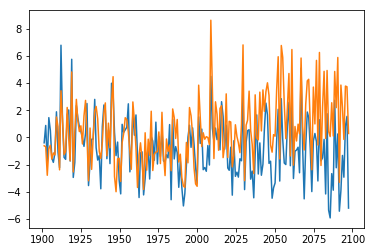

In [67]:
Plotting.time_plot(h85proj_eof2[0])
Plotting.time_plot(-1*aaproj[0])

In [53]:
SN=TOE(h85proj,noiseh85,starttime=starttime,L_init=L_init)    
SN_eof2=TOE(h85proj_eof2,noiseh85_eof2,starttime=starttime,L_init=L_init) 
SN_aa=TOE(aaproj,noiseaa,starttime=starttime,L_init=L_init) 

In [148]:
SN_trunc=TOE(h85proj_trunc_eof2,noiseh85_trunc_eof2,starttime=starttime,L_init=L_init)

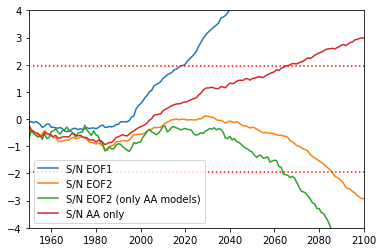

In [149]:
Plotting.time_plot(MV.average(SN,axis=0),label="S/N EOF1")
Plotting.time_plot(MV.average(SN_eof2,axis=0),label="S/N EOF2")
Plotting.time_plot(MV.average(SN_trunc,axis=0),label="S/N EOF2 (only AA models)")
Plotting.time_plot(-1*MV.average(SN_aa,axis=0),label="S/N AA only")
plt.axhline(1.96,c="r",ls=":")
plt.axhline(-1.96,c="r",ls=":")
plt.xlim(1950,2100)
plt.ylim(-4,4)
plt.legend()

In [20]:
       
                
def get_obs_data(dataset):    
    """
    Get east, west, and total Sahel precipitation data.  
    Dataset can be one of
    *CMAP
    *GPCP
    *PRECL
    """
    f=cdms.open(cmip_directory+"cmip5.sahel_precip."+experiment+".nc")
    east=f("pr_CE")
    west=f("pr_W")
    total=f("pr_sahel")
    f.close()
    return west,east,total

# Fingerprints
The fingerprint of a particular forcing or collection of forcings is calculated as the leading EOF of the multi-model mean of the CMIP5 simulations containing that forcing.

In [21]:
west,east,west_intensity,east_intensity=get_cmip5_data("historical-rcp85")
west_r=by_month(west_intensity)
west_r_a=MV.average(cmip5.ensemble2multimodel(west_r),axis=0)
west_r_clim=MV.average(west_r_a,axis=0)

east_r=by_month(east_intensity)
east_r_a=MV.average(cmip5.ensemble2multimodel(east_r),axis=0)
east_r_clim=MV.average(east_r_a,axis=0)

NameError: name 'get_cmip5_data' is not defined

In [ ]:
def plot_monthly_polar(data,ax,**kwargs):
   # if ax is None:
      #  ax=plt.subplot(1,1,1,projection='polar')
    theta=np.linspace(0,2*np.pi,13)[:-1]
    if data.shape==(12,):
        ax.plot(theta,data,"o-",**kwargs)
    else:
        L=float(data.shape[0])
        i=0
        for datum in data:
            ax.plot(theta,datum,"o-",color=cm.RdYlBu(i/L))
            i+=1
    months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    plt.thetagrids(np.rad2deg(theta),months)
    return ax

In [ ]:
data=west_r_clim.asma()
ax=plt.subplot(1,1,1,projection='polar')
plot_monthly_polar(west_r_a.asma()[::10],ax=ax)
#plot_monthly_polar(east_r_clim.asma(),ax=ax,c="k")
data.shape
ax.plot([0,np.pi/2],[1,1])